In [21]:
import pandas as pd
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner, PathologicalPartitioner
from datasets import Dataset
from modules.visualization_functions import showDataDist
from modules.common_fun import show_num_samples_per_client
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from modules.common_fun import preprocess_data

In [ ]:
# iid_partitions = FederatedDataset(
#     dataset="scikit-learn/adult-census-income",
#     partitioners={"train": 3}
# )

non_iid_partitions = FederatedDataset(
    dataset="scikit-learn/adult-census-income",
    partitioners={"train": DirichletPartitioner(num_partitions=3, partition_by="income", alpha=0.5, min_partition_size=2000)}
)

In [ ]:
# print("Number of samples per client ID (IID):")
# show_num_samples_per_client(iid_partitions, 3)

print("Number of samples per Client ID (non-IID):")
show_num_samples_per_client(non_iid_partitions, 3)

Number of samples per client ID (IID):
Client 0 → 10854 samples
Client 1 → 10854 samples
Client 2 → 10853 samples
Number of samples per Client ID (non-IID):
Client 0 → 7184 samples
Client 1 → 9713 samples
Client 2 → 15664 samples


c:\Users\prem2\miniconda3\envs\dataAnSc\Lib\site-packages\flwr_datasets\partitioner\dirichlet_partitioner.py:300: UserWarning: The specified min_partition_size (2000) was not satisfied for alpha ([0.5]) after 0 attempts at sampling from the Dirichlet distribution. The probability sampling from the Dirichlet distribution will be repeated. Note: This is not a desired behavior. It is recommended to adjust the alpha or min_partition_size instead. Generating partitions by sampling from a list of very wide range of alpha values can be hard to achieve. Try reducing the range between maximum (0.5) and minimum alpha (0.5) values or increasing all the values.
  warnings.warn(


Data distribution for IID partitions:


c:\Users\prem2\miniconda3\envs\dataAnSc\Lib\site-packages\flwr_datasets\metrics\utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(


Data distribution for non-IID partitions:


c:\Users\prem2\miniconda3\envs\dataAnSc\Lib\site-packages\flwr_datasets\metrics\utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(


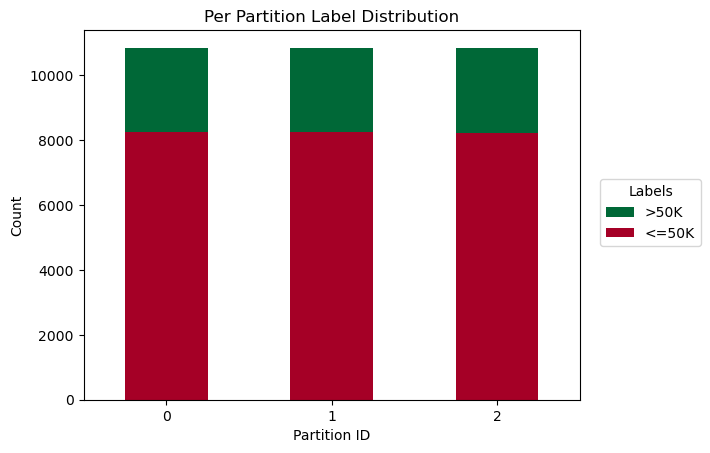

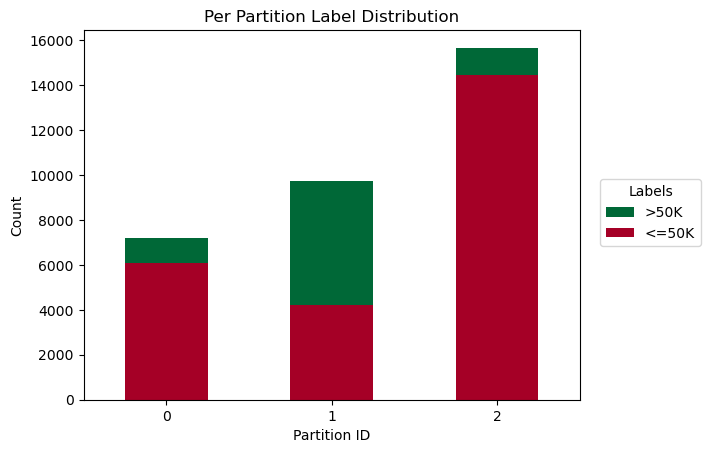

In [ ]:
# print("Data distribution for IID partitions:")
# showDataDist(iid_partitions, "income")

print("Data distribution for non-IID partitions:")
showDataDist(non_iid_partitions, "income")

In [23]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

def show_num_samples_per_client(partitions, number_of_clients):
    for client_id in range(number_of_clients):
        print(f"Client {client_id} → {partitions.load_partition(client_id).num_rows} samples")
        
        
def preprocess_data(pdf):
    """
    Preprocesses the input pandas DataFrame by:
    1. Replacing '?' with NaN and dropping rows with NaN values.
    2. Renaming columns to replace '.' with '_'.
    3. One-hot encoding specified categorical columns ('workclass', 'occupation', 'native_country', 'income').
    4. Concatenating the original DataFrame with the one-hot encoded DataFrame.
    5. Dropping the original categorical columns and other specified columns ('race', 'relationship', 'marital_status', 'fnlwgt', 'education', 'sex').

    Args:
        pdf (pd.DataFrame): The input pandas DataFrame.

    Returns:
        pd.DataFrame: The preprocessed pandas DataFrame.
    """    
    pdf.replace("?", np.nan, inplace=True)
    pdf = pdf.dropna()
    
    new_col_name = []

    for col in pdf.columns:
        new_col_name.append(col.replace(".", "_"))
        
    pdf = pdf.rename(columns=dict(zip(pdf.columns, new_col_name)))
        
    columns_to_encode = ["workclass", "occupation", "native_country", "income"]

    encoder = OneHotEncoder(drop = 'first', handle_unknown="error", dtype=np.int8)
    encoded_data = encoder.fit_transform(pdf[columns_to_encode]).toarray()

    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(), index=pdf.index)
    
    pdf_final = pd.concat([pdf, encoded_df], axis=1)

    pdf_final = pdf_final.drop(columns=["workclass", "occupation", "native_country", "income", "race", "relationship", "marital_status", "fnlwgt", "education", "sex"])
    
    return pdf_final

In [25]:
pdf = preprocess_data(non_iid_partitions.load_partition(0).to_pandas())

In [26]:
pdf.shape

(6644, 65)

In [27]:
display(pdf)

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia,income_>50K
0,19,10,0,0,16,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,22,10,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,40,9,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,33,9,0,0,40,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,44,13,0,0,60,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7179,52,9,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
7180,53,14,7298,0,60,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
7181,27,13,0,0,20,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
7182,21,12,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
